## Author: Стурейко Игорь
### Course: Geekbrains.DataLibraries.2
### Project: Предстказание дефолта
### Date: 2020-10-02

### Построение курсового проекта
* Обзор обучающего датасета
* Обработка выбросов
* Обработка пропусков
* Анализ данных
* Отбор признаков
* Балансировка классов
* Подбор моделей, получение бейзлана
* Выбор наилучшей модели, настройка гиперпараметров
* Проверка качества, борьба с переобучением
* Интерпретация результатов

* [Описание датасета](#dataset_describe)
    * [Загрузка данных](#data_load)
* [Пропуски данных](#data_missings)
    * [Заполнение пропусков](#fill_missings)
    * [Сохранение после заполнения пропусков](#save_missings)
* [Выбросы данных](#data_ejections)

## Описание датасета<a class="anchor" id="dataset_describe"></a>

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### Исходные данные<a class="anchor" id="data_load"></a>

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

### Загрузка и обзор данных

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_original = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df.shape

(7500, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Уменьшим объем памяти (по возможности)

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [29]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [30]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

## Обработка пропусков<a class="anchor" id="data_missings"></a>

In [8]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

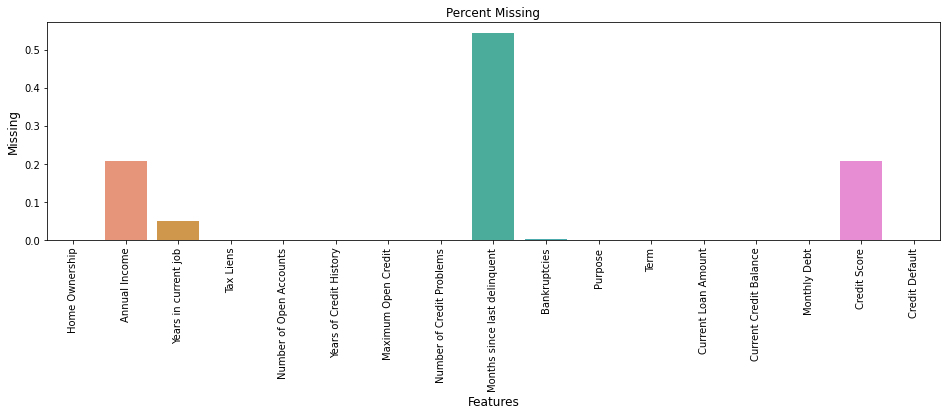

In [9]:
nan_df = (df.isna().sum() / df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(x=nan_df['feature'], y=nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Заполнение пропусков<a class="anchor" id="fill_missings"></a>

In [10]:
# по смыслу поле 'Months since last delinquent' = NaN означает отсутствие пропуска -> =0
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

! Пстроить модели для заполнения пропусков

In [11]:
# поле 'Annual Income' - при отсутствии заполняем медианой
# df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].median()

In [12]:
# поле 'Credit Score' - при отсутствии заполняем медианой
# df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].median()

In [13]:
# поле 'Years in current job' - при отсутствии заполняем модой
# df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [14]:
#'Bankruptcies' - при отсутствии заполняем модой
# df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].mode()[0]

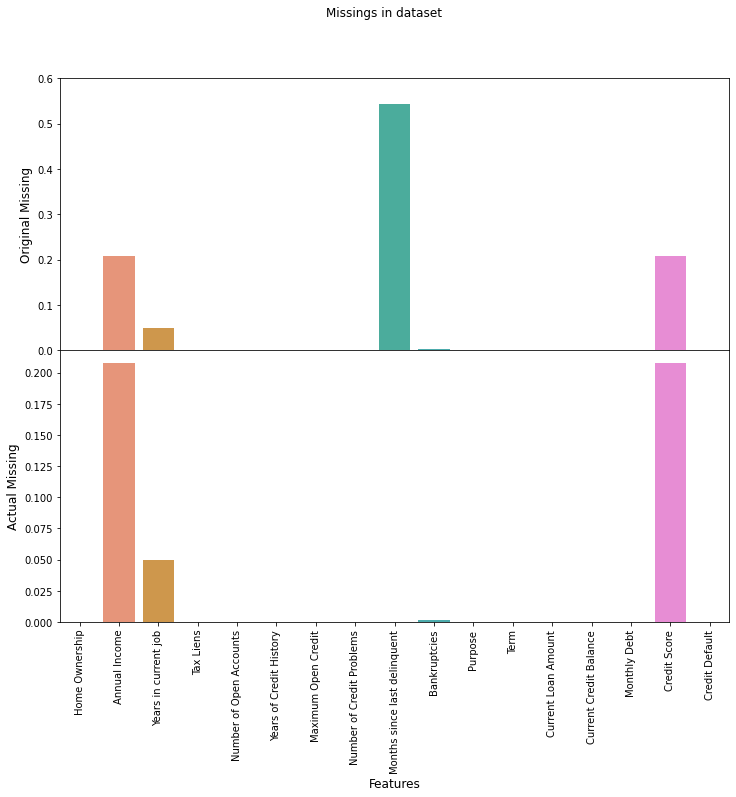

In [27]:
plt.figure(figsize = (12, 10))
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplot(211)
nan_df = (df_original.isna().sum() / df_original.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

sns.barplot(x=nan_df['feature'], y=nan_df['nan_percent'])
plt.ylabel('Original Missing', fontsize=12)
plt.xticks(rotation=90)
plt.ylim(top=0.6)

plt.subplot(212)
nan_df = (df.isna().sum() / df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

sns.barplot(x=nan_df['feature'], y=nan_df['nan_percent'])
plt.ylabel('Actual Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
# plt.ylim(top=0.6)

plt.suptitle('Missings in dataset')
plt.show()

In [ ]:
len(df) - df.count()

In [ ]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

### Добавление id

In [ ]:
df['ID'] = df.index.tolist()

### Сохранение датасета после очистки пропусков<a class="anchor" id="save_missings"></a>

In [ ]:
PREP_DATASET_PATH = 'course_project_train_prep.csv'

In [ ]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

## Работа с выбросами и ошибками<a class="anchor" id="data_ejections"></a>

In [ ]:
# количество записей где сумма максимального кредита = 0
df.loc[df['Maximum Open Credit'] == 0].shape

In [ ]:
# меняем сумму максимального кредита на сумму текущего
df.loc[df['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = df['Current Loan Amount']

In [ ]:
# количество записей с текущей суммой кредита больше чем максимально выданный
df.loc[df['Current Loan Amount'] > df['Maximum Open Credit']].shape

In [ ]:
# Два варианта:
# Текущая сумма правильная - тогда изменить максимальную сумму кредита
# Максимальная сумма правильная - тогда изменить текущую сумму

In [ ]:
sns.kdeplot(df['Current Loan Amount'], shade=True, legend=False)
plt.show()

In [ ]:
df.loc[df['Current Loan Amount'] > 1e7, ['Current Loan Amount', 'Maximum Open Credit']]

In [ ]:
# В случае когда текущий кредит = 1е8, скорее всего правильная сумма 
# максимально выданного кредита, меняем эти значения
df.loc[df['Current Loan Amount'] > 1e7, 'Current Loan Amount'] = df['Maximum Open Credit']

In [ ]:
# количество записей с текущей суммой кредита больше чем максимально выданный
df.loc[df['Current Loan Amount'] > df['Maximum Open Credit']].shape

In [ ]:
df.loc[df['Current Loan Amount'] > df['Maximum Open Credit'], ['Current Loan Amount', 'Maximum Open Credit']]

In [ ]:
# Сохранить датасет
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

_Можно поработать с помощью реализации одноклассовой машины опорных векторов (One-class Support Vector Machine) в библиотеке Scikit-learn_ 

https://habr.com/ru/post/251225/